<a href="https://colab.research.google.com/github/imshivaram/DL-project/blob/main/food_insecurity_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed forward neural network prediction model

#Import libraries

Data Preparation and Processing

Import Libraries

In [9]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import shap
import itertools
import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [10]:
# Load the Excel file
file_url = 'https://docs.google.com/spreadsheets/d/19K-Vlw8kxo-WMI2vSd1TxtCQfAvbsb6o/export?format=xlsx'
local_file_path = '2025 County Health Rankings Data - v3.xlsx'

Prompt: Load the two specific sheets from it: 'Select Measure Data' and 'Additional Measure Data'. Skip the first row, use the second row as headers, and specify the openpyxl engine

In [12]:
# Download the file
response = requests.get(file_url)
response.raise_for_status()
with open(local_file_path, 'wb') as f:
    f.write(response.content)
print(f"Downloaded file to {local_file_path}")



# Load the two specific sheets, skipping the first row and using the second row as headers
select_df = pd.read_excel(local_file_path, sheet_name='Select Measure Data', skiprows=1, header=0, engine='openpyxl')
additional_df = pd.read_excel(local_file_path, sheet_name='Additional Measure Data', skiprows=1, header=0, engine='openpyxl')
if 'metadata' in additional_df and 'widgets' in additional_df['metadata']:
    del additional_df['metadata']['widgets']
print("Successfully loaded data from Excel sheets.")

Downloaded file to 2025 County Health Rankings Data - v3.xlsx
Successfully loaded data from Excel sheets.


Prompt: Combine them into one main dataframe df by matching on the columns 'FIPS', 'State', and 'County' using a left join. Then, clean up the column names by removing any extra spaces at the start or end

In [13]:
# Merge the two DataFrames on ['FIPS', 'State', 'County'] with left join
df = pd.merge(select_df, additional_df, on=['FIPS', 'State', 'County'], how='left')
df.columns = df.columns.str.strip()

Prompt: Display all column names row-wise each on its own line and display size limit

In [14]:
pd.set_option('display.max_columns', None)
for i, column in enumerate(df.columns, 1):
    print(f"{i:3d}. {column}")

  1. FIPS
  2. State
  3. County
  4. Unreliable
  5. Deaths
  6. Years of Potential Life Lost Rate
  7. 95% CI - Low_x
  8. 95% CI - High_x
  9. National Z-Score
 10. YPLL Rate (Hispanic (all races))
 11. YPLL Rate (Hispanic (all races)) 95% CI - Low
 12. YPLL Rate (Hispanic (all races)) 95% CI - High
 13. YPLL Rate (Hispanic (all races)) Unreliable
 14. YPLL Rate (Non-Hispanic AIAN)
 15. YPLL Rate (Non-Hispanic AIAN) 95% CI - Low
 16. YPLL Rate (Non-Hispanic AIAN) 95% CI - High
 17. YPLL Rate (Non-Hispanic AIAN) Unreliable
 18. YPLL Rate (Non-Hispanic Asian)
 19. YPLL Rate (Non-Hispanic Asian) 95% CI - Low
 20. YPLL Rate (Non-Hispanic Asian) 95% CI - High
 21. YPLL Rate (Non-Hispanic Asian) Unreliable
 22. YPLL Rate (Non-Hispanic Black)
 23. YPLL Rate (Non-Hispanic Black) 95% CI - Low
 24. YPLL Rate (Non-Hispanic Black) 95% CI - High
 25. YPLL Rate (Non-Hispanic Black) Unreliable
 26. YPLL Rate (Non-Hispanic Native Hawaiian and Other Pacific Islander)
 27. YPLL Rate (Non-Hispanic Nat

Prompt: Organize the features by grouping them into categories: one for social and economic like unemployment and poverty rates, one for environment like exercise access and food index, one for env_features like Access to Exercise Opportunities, Food Environment Index and Water Violation and one for health like doctor and vaccination rates, and one for policy and demographics like segregation and pay gap. Use the exact column names from the data for each list

In [15]:
# Define feature lists by category
socio_features = [
    '% Unemployed', 'Income Ratio', '% Children in Poverty', '% Some College',
    '% Completed High School', '% Children in Single-Parent Households', '% Below 18 Years of Age',
    '% with disability', '% Not Proficient in English', '% Disconnected Youth' ]
env_features = [
    '% With Access to Exercise Opportunities', 'Food Environment Index',
    'Average Daily PM2.5', 'Presence of Water Violation', '% Limited Access to Healthy Foods',
    '% Rural', '% Drive Alone to Work', '% Long Commute - Drives Alone', '% Households with Severe Cost Burden',
    '% feeling lonely' ]
health_features = [
    'Primary Care Physicians Rate', 'Mental Health Provider Rate', 'Dentist Rate',
    'Preventable Hospitalization Rate', '% Vaccinated', '% Adults with Obesity',
    '% Fair or Poor Health', '% Frequent Physical Distress', '% Frequent Mental Distress',
    '% Adults Reporting Currently Smoking', '% Physically Inactive', '% Uninsured Adults',
    '% Uninsured Children', '% Low Birth Weight', '% Adults with Diabetes' ]
policy_demo_features = [
    'Segregation Index.1', 'Segregation Index', 'Gender Pay Gap',
    '% Non-Hispanic Black', '% Hispanic', '% American Indian or Alaska Native',
    '% Asian', '% Native Hawaiian or Other Pacific Islander', '% Non-Hispanic White',
    '% 65 and Over', '% Female', 'Suicide Rate', 'Homicide Rate', 'Motor Vehicle Mortality Rate',
    'Firearm Fatalities Rate' ]

Prompt: Combine all those lists into one single list for all the features together. Also, set the target column name to '% Food Insecure' in a variable

In [16]:
# All features
feature_cols = socio_features + env_features + health_features + policy_demo_features
target_col = '% Food Insecure'

Prompt: Filter the main dataframe df to only keep the 'FIPS' column, plus features from my feature_cols list that actually exist in the data, and the target column. Then, remove any rows where 'FIPS' or the target is missing. Save the result back to df

In [17]:
# Select only available features and target
available_features = [col for col in feature_cols if col in df.columns]
df = df[['FIPS'] + available_features + [target_col]]
df = df.dropna(subset=['FIPS', target_col])

In [18]:
df.shape

(3195, 51)

Prompt: Convert the target column and all the available features to proper numeric values as float point numbers, turning any non-numeric entries into missing values

In [19]:
# Convert to numeric
df[target_col] = pd.to_numeric(df[target_col], errors='coerce').astype('float64')
for col in available_features:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')

Prompt: Remove any features from the available_features list that are completely empty I mean all missing values in the dataframe df. Then update df to only include the 'FIPS' column, the remaining available features and the target column

In [20]:
# Exclude entirely NaN columns
available_features = [col for col in available_features if not df[col].isna().all()]
df = df[['FIPS'] + available_features + [target_col]]

In [21]:
print(f"Dataset shape after selection: {df.shape}")
print(f"Available features: {len(available_features)}/{len(feature_cols)}")

Dataset shape after selection: (3195, 50)
Available features: 48/50


Prompt: Display summary of the key statistics for the available features and the target column, such as the count, mean, standard deviation, min, max, and quartiles. Calculate and Disply the count of missing values for each column, but only display those columns that have at least one missing value

In [22]:
# Statistics
print("\nDataset Summary Statistics:")
print(df[available_features + [target_col]].describe())

print("\nMissing Values per Column:")
missing_counts = df[available_features + [target_col]].isnull().sum()
print(missing_counts[missing_counts > 0])


Dataset Summary Statistics:
       % Unemployed  Income Ratio  % Children in Poverty  % Some College  \
count   3185.000000   3173.000000            3194.000000     3194.000000   
mean       3.586037      4.562373              18.932999       59.327274   
std        1.216611      0.808150               8.021056       11.689973   
min        0.312305      2.271341               3.100000       16.805787   
25%        2.801120      4.028389              13.000000       51.593659   
50%        3.402445      4.424203              17.800000       59.407435   
75%        4.150566      4.957184              23.300000       67.557044   
max       17.268808     10.496679              63.200000       93.207037   

       % Completed High School  % Children in Single-Parent Households  \
count              3195.000000                             3193.000000   
mean                 88.794023                               23.870699   
std                   5.449945                               10.

Prompt: Create a simple histogram chart showing the distribution of the target column '% Food Insecure', add a title 'Distribution of % Food Insecure', label the x-axis '% Food Insecure' and y-axis 'Frequency'. Just display it

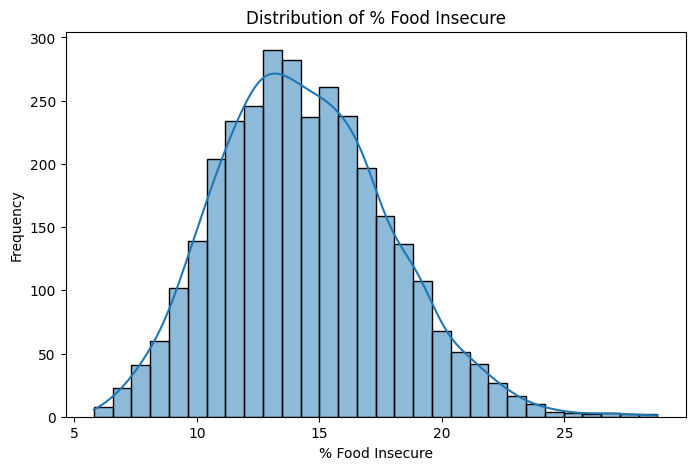

In [23]:
# Visualization: Target distribution
plt.figure(figsize=(8, 5))
sns.histplot(df[target_col], kde=True, bins=30)
plt.title('Distribution of % Food Insecure')
plt.xlabel('% Food Insecure')
plt.ylabel('Frequency')
plt.show()

Prompt: Create a clear visualization focused only on how strongly each feature correlates with the target column, sorted from highest to lowest. Use a horizontal bar chart for readability, with a vertical line at zero to show positive and negative directions, and include a title like 'Feature Correlations with % Food Insecure'

<Figure size 1400x1200 with 0 Axes>

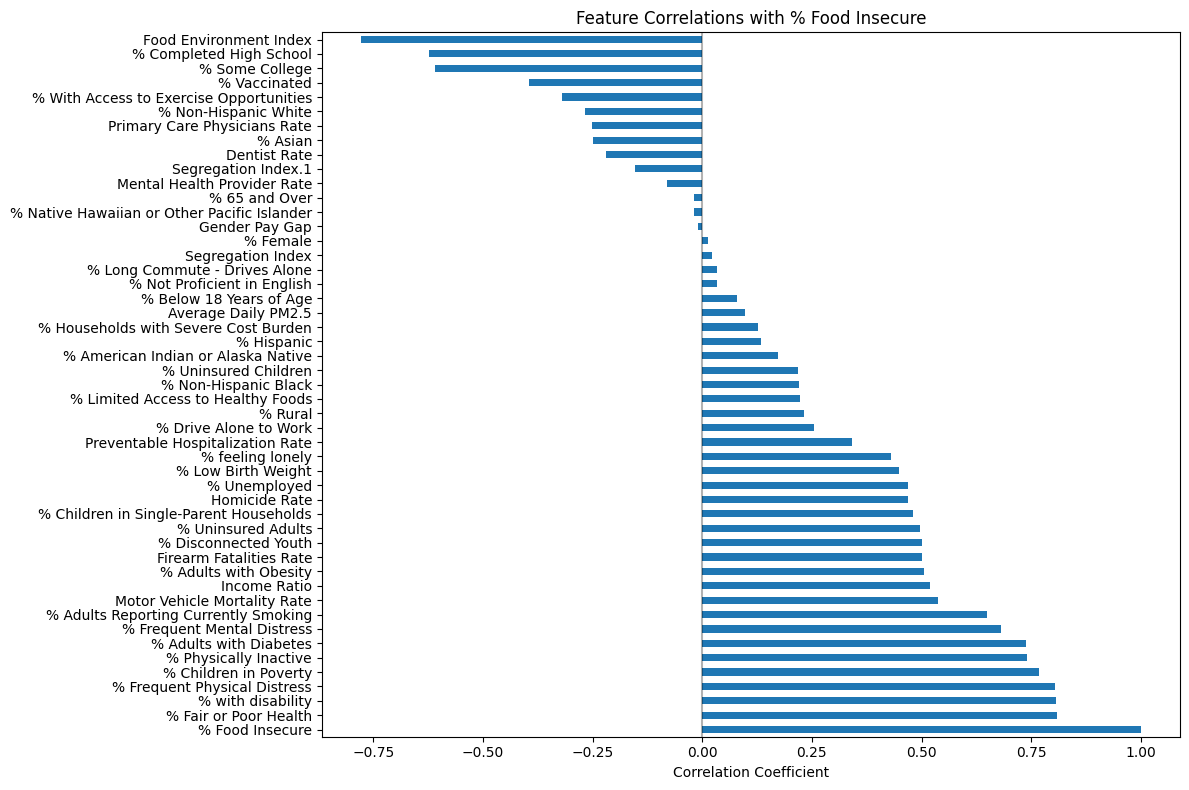

In [24]:
# Show only top correlations with target

# Clean correlation heatmap
plt.figure(figsize=(14, 12))

# Calculate correlation matrix
corr_matrix = df[available_features + [target_col]].corr()

# Get correlations with target and sort
target_correlations = corr_matrix[target_col].sort_values(ascending=False)

# Plot as bar chart (often clearer for many features)
plt.figure(figsize=(12, 8))
target_correlations.plot(kind='barh')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'Feature Correlations with {target_col}')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Data Handling: Missing Data, Dimensionality Reduction, Feature Selection

Prompt: Separate the available features into a matrix called X, ensuring it only includes the numeric columns from the available_features list, and set the target column '% Food Insecure' as a separate variable y. Display the shape of the original X

In [25]:
# Separate features and target
X = df[available_features].select_dtypes(include=[np.number])
y = df[target_col]

print(f"Original data shape: {X.shape}")

Original data shape: (3195, 48)


In [26]:
X

,% Unemployed,Income Ratio,% Children in Poverty,% Some College,% Completed High School,% Children in Single-Parent Households,% Below 18 Years of Age,% with disability,% Not Proficient in English,% Disconnected Youth,% With Access to Exercise Opportunities,Food Environment Index,Average Daily PM2.5,% Limited Access to Healthy Foods,% Rural,% Drive Alone to Work,% Long Commute - Drives Alone,% Households with Severe Cost Burden,% feeling lonely,Primary Care Physicians Rate,Mental Health Provider Rate,Dentist Rate,Preventable Hospitalization Rate,% Vaccinated,% Adults with Obesity,% Fair or Poor Health,% Frequent Physical Distress,% Frequent Mental Distress,% Adults Reporting Currently Smoking,% Physically Inactive,% Uninsured Adults,% Uninsured Children,% Low Birth Weight,% Adults with Diabetes,Segregation Index.1,Segregation Index,Gender Pay Gap,% Non-Hispanic Black,% Hispanic,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Non-Hispanic White,% 65 and Over,% Female,Homicide Rate,Motor Vehicle Mortality Rate,Firearm Fatalities Rate
0,2.498243,5.167305,21.3,61.772770,88.128041,30.646855,22.136578,33.5,1.119198,7.571883,61.413190,5.3,8.6,8.760549,42.262760,81.456159,35.8,12.328581,33.4,63.65235,146.22779,49.60294,3327.0,41.0,38.4,21.8,13.1,18.7,16.2,27.8,13.290186,3.062534,10.497739,13.5,57.708674,0.270292,0.747823,26.234088,5.685540,0.749364,1.598620,0.118920,64.104698,18.250325,51.467779,12.732604,20.679993,23.659953
1,2.188889,4.273712,17.0,61.378732,90.278902,22.261332,23.348580,31.1,0.392087,NaN,54.491965,6.8,9.3,13.020998,40.676813,84.916222,42.1,9.823338,34.3,43.99695,36.45885,30.12099,4365.0,36.0,38.4,17.7,12.1,18.0,15.4,25.7,10.349357,2.670088,9.995826,11.3,33.959314,0.058234,0.706880,20.990355,3.853038,0.495509,1.309204,0.139207,71.363230,16.782672,51.481555,8.052563,17.866624,17.453896
2,2.279497,4.359526,14.1,64.847875,91.731400,19.628273,20.950112,29.6,0.836934,8.054458,61.624390,7.4,7.8,7.936779,37.586455,80.296745,38.1,11.551478,31.6,62.68440,120.70673,47.07124,2888.0,44.0,36.8,17.0,12.1,18.2,14.7,23.8,12.705830,3.512242,8.133286,10.2,42.652640,0.085722,0.721986,8.221469,5.782089,0.848892,1.151447,0.069426,82.267945,22.059746,51.284580,3.866969,15.024124,14.961877
3,4.431017,5.614339,34.8,44.077431,77.813705,51.937984,20.614196,40.7,1.616974,NaN,54.858661,6.2,8.8,10.433172,65.919994,82.408501,37.5,10.666029,35.7,40.05768,28.47265,32.38080,3560.0,39.0,43.8,28.4,16.8,21.1,21.9,34.9,15.801392,3.070523,12.454212,16.0,22.729420,0.035611,0.770342,46.483628,6.211104,0.829774,0.581655,0.305064,44.763067,20.581655,46.853773,13.138278,25.705326,26.650300
4,2.462380,5.346727,21.4,43.533225,80.340217,31.218962,19.873788,37.0,0.692501,NaN,43.390302,7.3,8.6,0.445866,100.000000,87.893346,53.5,11.006993,36.3,66.73488,36.58314,22.72211,5029.0,31.0,41.4,25.1,16.1,21.3,21.8,32.2,13.471330,3.541807,10.017472,13.3,40.009999,0.089632,0.822826,20.367661,3.612585,0.594476,0.297238,0.146333,73.705872,18.286995,47.274556,7.656821,24.246601,21.541665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,3.338107,4.525023,11.5,62.360227,92.531165,17.120106,24.453926,30.9,0.796449,NaN,92.621593,7.7,3.6,5.226624,10.754164,79.244065,19.5,10.107291,30.5,43.25467,249.70302,60.46680,1640.0,39.0,36.3,15.9,12.3,17.3,17.9,22.4,15.533036,7.646783,10.179104,9.4,74.183082,0.032927,0.642639,1.054571,16.827075,1.481248,0.918810,0.169701,78.632209,15.668259,48.076317,NaN,16.737802,27.484765
3206,2.146938,4.013741,5.7,77.143904,97.159566,14.727723,16.752755,22.1,3.366222,NaN,99.228494,8.7,4.8,3.811752,53.881102,62.596805,11.7,12.898213,29.9,93.31919,645.66116,107.35604,1522.0,56.0,22.2,10.6,9.0,13.5,11.3,15.4,17.069804,8.317536,7.748344,7.1,NaN,0.077915,0.875162,0.822142,15.581956,1.205234,1.919766,0.172176,79.812328,18.526171,47.550792,NaN,7.345739,14.541846
3207,3.177221

Prompt: Fill in any missing values in X by replacing them with the median value for each column. Use a tool called SimpleImputer with the median strategy, fit and apply it to X, then save the cleaned data as a DataFrame called X_imputed with the same columns and row labels. Print the total number of missing values left, which should be zero

In [27]:
# Missing value handling: Median imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")

Missing values after imputation: 0


Prompt: Select the top features that best relate to the target y by using a method called mutual information, which scores how informative each feature is. Set it to pick up to 38 features, fit the selector on X_imputed and y, extract the selected feature names and their scores, and Display the header like "Top number features by Mutual Information:" followed by each feature name and its score rounded to 4 decimal places

In [28]:
# Feature Selection: Mutual Information - KEEP 38 FEATURES
k = min(38, X_imputed.shape[1])
selector = SelectKBest(score_func=mutual_info_regression, k=k)
X_selected = selector.fit_transform(X_imputed, y)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()

print(f"\nTop {X_selected.shape[1]} features by Mutual Information:")
mi_scores = selector.scores_[selected_indices]
for feature, score in zip(selected_features, mi_scores):
    print(f"  {feature}: {score:.4f}")


Top 38 features by Mutual Information:
  % Unemployed: 0.1367
  Income Ratio: 0.1822
  % Children in Poverty: 0.5017
  % Some College: 0.2316
  % Completed High School: 0.2811
  % Children in Single-Parent Households: 0.1447
  % with disability: 0.5453
  % Disconnected Youth: 0.0799
  % With Access to Exercise Opportunities: 0.0596
  Food Environment Index: 0.7019
  Average Daily PM2.5: 0.0684
  % Limited Access to Healthy Foods: 0.0455
  % Rural: 0.0400
  % Drive Alone to Work: 0.0747
  % feeling lonely: 0.1021
  Primary Care Physicians Rate: 0.0495
  Mental Health Provider Rate: 0.0281
  Dentist Rate: 0.0726
  Preventable Hospitalization Rate: 0.0432
  % Vaccinated: 0.1329
  % Adults with Obesity: 0.1970
  % Fair or Poor Health: 0.5244
  % Frequent Physical Distress: 0.5092
  % Frequent Mental Distress: 0.3356
  % Adults Reporting Currently Smoking: 0.2850
  % Physically Inactive: 0.4190
  % Uninsured Adults: 0.1916
  % Uninsured Children: 0.0423
  % Low Birth Weight: 0.1428
  % Adu

Prompt: Standardize them using StandardScaler to center at zero with unit variance: fit and transform to X_final, then print its shape

In [29]:
# Standardization on selected features
scaler = StandardScaler()
X_final = scaler.fit_transform(X_selected)

print(f"Final feature shape: {X_final.shape}")

Final feature shape: (3195, 38)


Model Setup and Prediction: FFNN with Hyperparameter Tuning, Validation

Prompt: Define the FFNN class extending torch's nn.Module: In init, build sequential layers loop hidden_sizes to add Linear plus ReLU, insert Dropout 0.3 after each except last, end with Linear to 1. Add forward method

In [30]:
# Custom NN class - INCREASE DROPOUT TO 0.3
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.3):
        super(FFNN, self).__init__()
        layers = []
        prev_size = input_size
        for i, hidden_size in enumerate(hidden_sizes):
            layers.extend([nn.Linear(prev_size, hidden_size), nn.ReLU()])
            if i < len(hidden_sizes) - 1:  # No dropout after last hidden layer
                layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


Prompt: Create the train_model function that takes X_train y_train X_val y_val plus params like hidden_sizes, lr, epochs, batch_size, patience, weight_decay. Convert to tensors, make train dataset loader, init FFNN, MSE, Adam optimizer, loop epochs for batch training and avg train loss, val eval no_grad and append val loss, track best val loss with early stop printing, load best state, return model and losses lists

In [31]:
def train_model(X_train, y_train, X_val, y_val, hidden_sizes=[128, 64], lr=0.001, epochs=100, batch_size=32, patience=10, weight_decay=1e-5):
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

    # Create datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = FFNN(X_train.shape[1], hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()

        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses


Prompt: Split X_final and y into train/temp 70/30 split, then split temp into val/test 50/50. Display the sample counts for training, validation, and test sets

In [32]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_final, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 2236 samples
Validation set: 479 samples
Test set: 480 samples


Prompt: Run a hyperparameter tuning process: Print a message saying Performing hyperparameter tuning, then define a grid dictionary param_grid with keys for hidden_sizes as [[128, 64], [256, 128]], lr as [0.001, 0.01], epochs as [100, 150], and weight_decay as [1e-5, 1e-4, 1e-3]. Initialize best_score to negative infinity, best_model to None, best_params to empty dict, and best_losses to None. Loop over all combinations using itertools.product, train the model for each set of params, evaluate on the validation set by setting eval mode, predicting with no_grad and torch tensor, compute R2 score, and update the best if this score is higher. Print the best parameters dictionary and the best R2 rounded to 4 decimals

In [33]:
# Hyperparameter Tuning - EXPAND GRID WITH weight_decay
print("\nPerforming hyperparameter tuning...")
param_grid = {
    'hidden_sizes': [[128, 64], [256, 128]],
    'lr': [0.001, 0.01],
    'epochs': [100, 150],
    'weight_decay': [1e-5, 1e-4, 1e-3]
}

best_score = -np.inf
best_model = None
best_params = {}
best_losses = None

for hidden, lr, epochs, wd in itertools.product(param_grid['hidden_sizes'], param_grid['lr'], param_grid['epochs'], param_grid['weight_decay']):
    model, train_losses, val_losses = train_model(X_train, y_train, X_val, y_val,
                      hidden_sizes=hidden, lr=lr, epochs=epochs, weight_decay=wd)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_pred_val = model(X_val_tensor).numpy().flatten()

    score = r2_score(y_val, y_pred_val)
    if score > best_score:
        best_score = score
        best_model = model
        best_params = {'hidden_sizes': hidden, 'lr': lr, 'epochs': epochs, 'weight_decay': wd}
        best_losses = (train_losses, val_losses)


print(f"Best params: {best_params}, Best R2: {best_score:.4f}")


Performing hyperparameter tuning...
Early stopping at epoch 65
Early stopping at epoch 96
Early stopping at epoch 68
Early stopping at epoch 71
Early stopping at epoch 57
Early stopping at epoch 84
Early stopping at epoch 51
Early stopping at epoch 42
Early stopping at epoch 31
Early stopping at epoch 43
Early stopping at epoch 21
Early stopping at epoch 24
Early stopping at epoch 73
Early stopping at epoch 81
Early stopping at epoch 57
Early stopping at epoch 54
Early stopping at epoch 79
Early stopping at epoch 75
Early stopping at epoch 19
Early stopping at epoch 27
Early stopping at epoch 40
Early stopping at epoch 47
Early stopping at epoch 77
Early stopping at epoch 45
Best params: {'hidden_sizes': [128, 64], 'lr': 0.001, 'epochs': 150, 'weight_decay': 0.001}, Best R2: 0.9679


Prompt: Create a line plot showing the training and validation losses over epochs from best_losses plot x-label 'Epoch', y-label 'MSE Loss', title 'Training History' and Display it

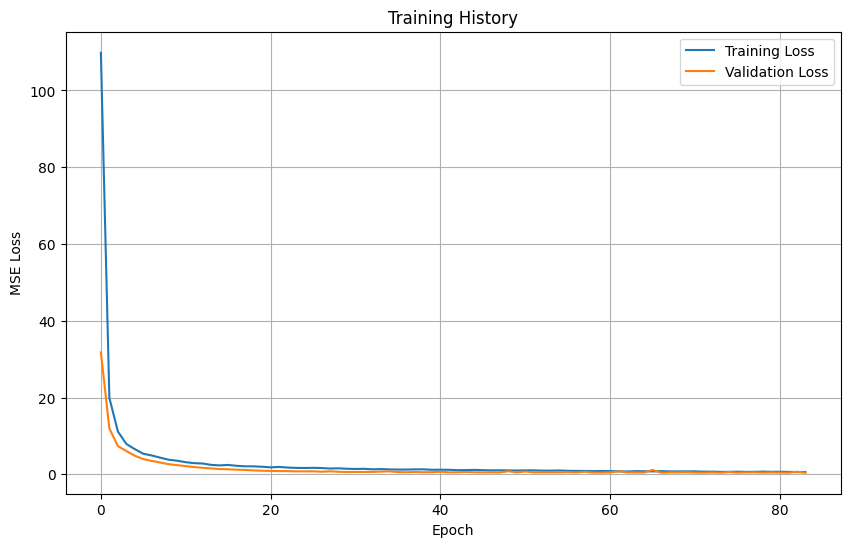

In [34]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(best_losses[0], label='Training Loss')
plt.plot(best_losses[1], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


Prompt: Evaluate the best model on the training set: Set eval mode, predict with no_grad on X_train tensor to y_pred_train, compute MSE, MAE, R2, and Display Final Train Performance

In [35]:
# Train evaluation
best_model.eval()
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_pred_train = best_model(X_train_tensor).numpy().flatten()

mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"\nFinal Train Performance:")
print(f"  MSE: {mse_train:.4f}")
print(f"  MAE: {mae_train:.4f}")
print(f"  R²: {r2_train:.4f}")


Final Train Performance:
  MSE: 0.2774
  MAE: 0.3028
  R²: 0.9762


Prompt: Evaluate the best model on the test set: Set eval mode, predict y_pred_test with no_grad on X_test tensor, compute MSE, MAE, R2, and Display Final Test Performance

In [36]:
# Final evaluation on test set
best_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_test = best_model(X_test_tensor).numpy().flatten()

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"\nFinal Test Performance:")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")


Final Test Performance:
  MSE: 0.5446
  MAE: 0.3792
  R²: 0.9534


Prompt: Create a scatter plot of actual y_test vs predicted y_pred_test , add a dashed diagonal line from min to max, label x 'Actual % Food Insecure' and y 'Predicted % Food Insecure', title 'Predictions vs Actual', light grid alpha=0.3. Add top-left text box with R square and MSE and Display

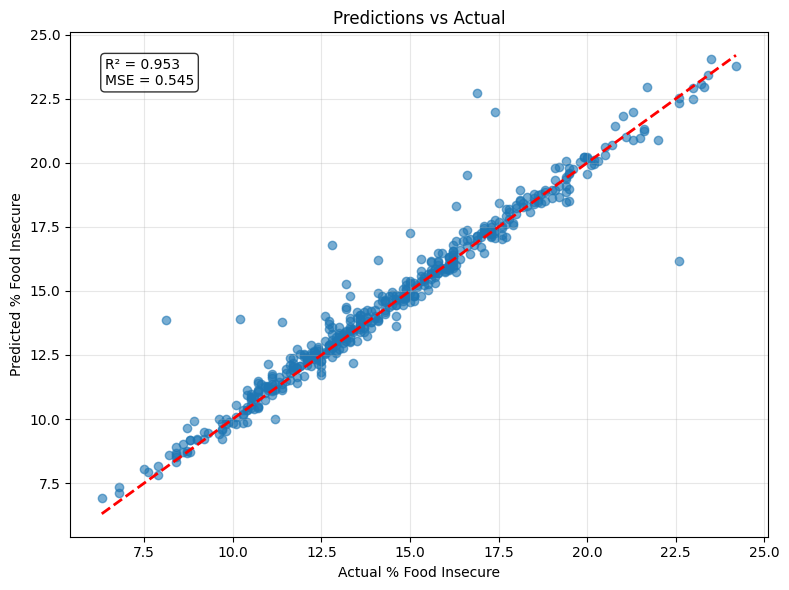

In [37]:
# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual % Food Insecure')
plt.ylabel('Predicted % Food Insecure')
plt.title('Predictions vs Actual')
plt.grid(True, alpha=0.3)

# Add metrics to plot
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nMSE = {mse:.3f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

K-Fold Cross-Validation

Prompt: Run 5-fold cross-validation: Print Performing 5-Fold Cross-Validation, create KFold n_splits=5 init lists for MSE, MAE, R2, loop enumerate splits print fold, extract train/val indices for X_final/y, train_model with best_params, eval val no_grad tensor predict flatten, append metrics, then compute avg,std, print results

In [38]:
print("\nPerforming 5-Fold Cross-Validation...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_mse = []
fold_mae = []
fold_r2 = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_final)):
    print(f"Fold {fold_idx + 1}/5:")
    X_train_fold = X_final[train_idx]
    X_val_fold = X_final[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    # Train model on this fold (using best params)
    model_fold, _, _ = train_model(
        X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        hidden_sizes=best_params['hidden_sizes'],
        lr=best_params['lr'],
        epochs=best_params['epochs'],
        weight_decay=best_params['weight_decay']
    )

    # Evaluate on val fold
    model_fold.eval()
    with torch.no_grad():
        X_val_fold_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_pred_fold = model_fold(X_val_fold_tensor).numpy().flatten()

    fold_mse.append(mean_squared_error(y_val_fold, y_pred_fold))
    fold_mae.append(mean_absolute_error(y_val_fold, y_pred_fold))
    fold_r2.append(r2_score(y_val_fold, y_pred_fold))

# Average metrics
avg_mse = np.mean(fold_mse)
avg_mae = np.mean(fold_mae)
avg_r2 = np.mean(fold_r2)
std_r2 = np.std(fold_r2)

print(f"\nK-Fold CV Results (5 Folds):")
print(f"  Avg MSE: {avg_mse:.4f} ± {np.std(fold_mse):.4f}")
print(f"  Avg MAE: {avg_mae:.4f} ± {np.std(fold_mae):.4f}")
print(f"  Avg R²: {avg_r2:.4f} ± {std_r2:.4f}")



Performing 5-Fold Cross-Validation...
Fold 1/5:
Early stopping at epoch 59
Fold 2/5:
Early stopping at epoch 64
Fold 3/5:
Early stopping at epoch 126
Fold 4/5:
Early stopping at epoch 51
Fold 5/5:
Early stopping at epoch 84

K-Fold CV Results (5 Folds):
  Avg MSE: 0.4852 ± 0.1441
  Avg MAE: 0.4122 ± 0.0531
  Avg R²: 0.9597 ± 0.0109


SHAP Analysis for Interpretability

Prompt: Start the SHAP analysis set X_original to X_imputed, then split it and y into train_orig/test_orig 0.3 test_size, random state

In [39]:
print("\nPerforming SHAP analysis...")

# FIX: Create a proper train-test split that preserves indices for SHAP
X_original = X_imputed

# Split the original data with the same random state
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y, test_size=0.3, random_state=42
)



Performing SHAP analysis...


Prompt: Apply the existing feature selector to both splits to get X_train_selected and X_test_selected, then scale them using the scaler to create X_train_scaled and X_test_scaled. Print the shapes of the scaled train and test data

In [40]:
# Apply the same feature selection and scaling to this split
X_train_selected = selector.transform(X_train_orig)
X_test_selected = selector.transform(X_test_orig)

X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print(f"SHAP training data: {X_train_scaled.shape}")
print(f"SHAP test data: {X_test_scaled.shape}")

SHAP training data: (2236, 38)
SHAP test data: (959, 38)


Prompt: Take the first 100 rows of X_train_scaled as background_data and first 50 of X_test_scaled as explanation_data, get original values and display shape

In [41]:
# Use a subset for faster SHAP computation
background_data = X_train_scaled[:100]
explanation_data = X_test_scaled[:50]

# FIX: Get the original feature values for the explanation data
X_test_original_values = X_test_orig.iloc[:50][selected_features].values

print(f"Background data for SHAP: {background_data.shape}")
print(f"Explanation data for SHAP: {explanation_data.shape}")
print(f"Original feature values for SHAP: {X_test_original_values.shape}")

Background data for SHAP: (100, 38)
Explanation data for SHAP: (50, 38)
Original feature values for SHAP: (50, 38)


Prompt: Define model_predict wrapper Creating KernelExplainer, make KernelExplainer with model_predict, calculate shap_values nsamples, print type,shape

In [42]:
# Use KernelExplainer for more reliable SHAP values
def model_predict(X):
    """Wrapper function for model prediction"""
    best_model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        return best_model(X_tensor).numpy().flatten()

# Create KernelExplainer
print("Creating KernelExplainer...")
kernel_explainer = shap.KernelExplainer(model_predict, background_data)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = kernel_explainer.shap_values(explanation_data, nsamples=100)

print(f"SHAP values type: {type(shap_values)}")
if hasattr(shap_values, 'shape'):
    print(f"SHAP values shape: {shap_values.shape}")

# FIX: Ensure shap_values is a proper 2D numpy array
if isinstance(shap_values, list):
    shap_values = np.array(shap_values)

# If shap_values is 1D, reshape it to 2D
if len(shap_values.shape) == 1:
    shap_values = shap_values.reshape(1, -1)

print(f"Final SHAP values shape: {shap_values.shape}")

Creating KernelExplainer...
Calculating SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (50, 38)
Final SHAP values shape: (50, 38)


Prompt: Get the SHAP Summary & Bar Plots

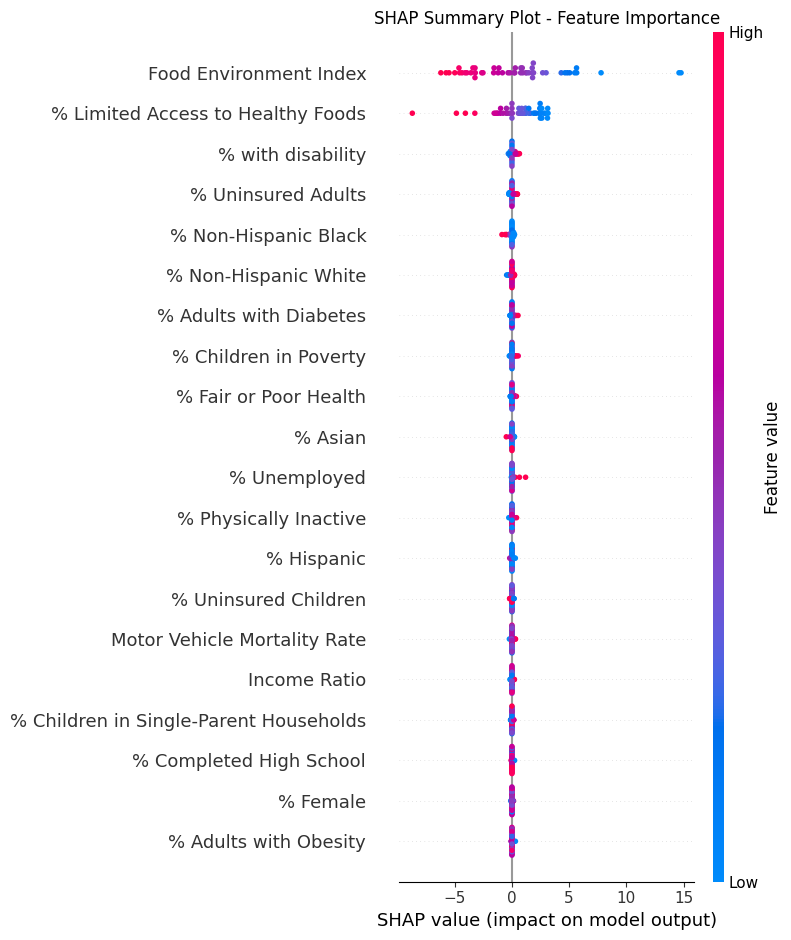

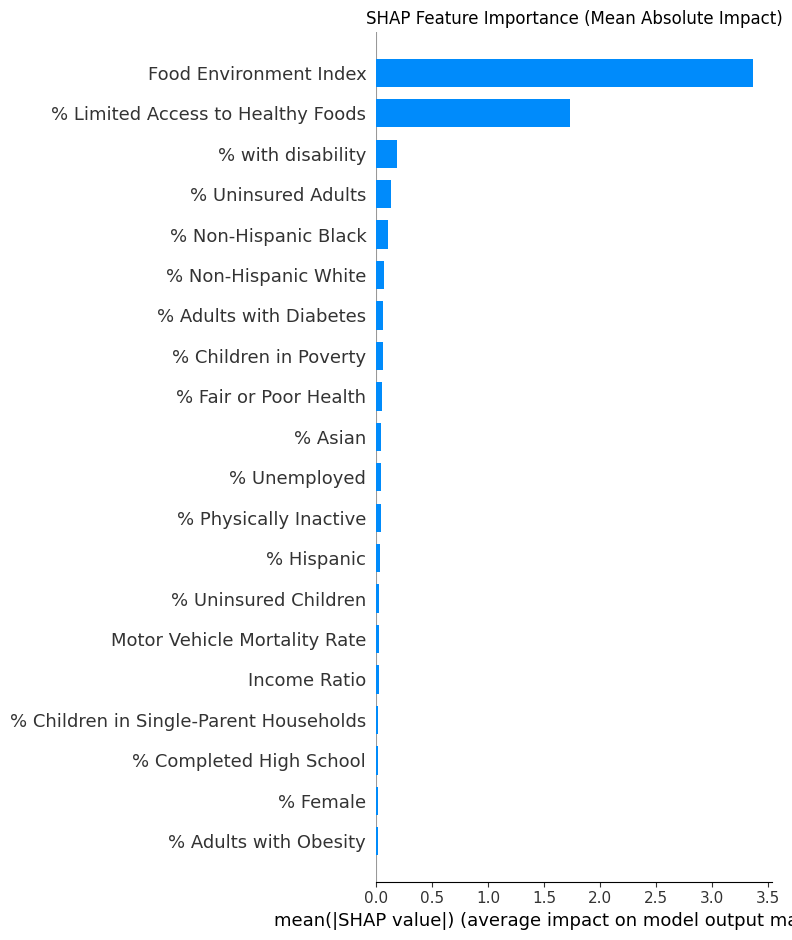

SHAP analysis completed successfully!


In [43]:
# Create SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_original_values, feature_names=selected_features, show=False)
plt.title('SHAP Summary Plot - Feature Importance')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Create SHAP bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_original_values, feature_names=selected_features, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute Impact)')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP analysis completed successfully!")

Prompt: Handle SHAP for Importance & Create DF and Print Top importantce

In [44]:
# FIX: Properly handle SHAP values for feature importance calculation
if len(shap_values.shape) == 2:
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
else:
    print(f"Warning: Unexpected SHAP values shape: {shap_values.shape}")
    mean_abs_shap = np.abs(shap_values).flatten()
    if len(mean_abs_shap) > len(selected_features):
        mean_abs_shap = mean_abs_shap[:len(selected_features)]

print(f"Mean absolute SHAP values shape: {mean_abs_shap.shape}")

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Mean |SHAP|': mean_abs_shap,
    'MI Score': mi_scores
}).sort_values('Mean |SHAP|', ascending=False)

print("\nTop features by SHAP importance:")
print(feature_importance_df.head(10))

Mean absolute SHAP values shape: (38,)

Top features by SHAP importance:
                              Feature  Mean |SHAP|  MI Score
9              Food Environment Index     3.368458  0.701864
11  % Limited Access to Healthy Foods     1.732038  0.045541
6                   % with disability     0.185401  0.545276
26                 % Uninsured Adults     0.131487  0.191602
30               % Non-Hispanic Black     0.111687  0.030454
33               % Non-Hispanic White     0.073994  0.093874
29             % Adults with Diabetes     0.063736  0.403486
2               % Children in Poverty     0.063143  0.501734
21              % Fair or Poor Health     0.055314  0.524369
32                            % Asian     0.048919  0.071693


Prompt: Get the Correlation with Target & print it

In [45]:
# Correlation with target
target_correlations = []
for feature in selected_features:
    corr = df[feature].corr(df[target_col])
    target_correlations.append(corr)

feature_importance_df['Correlation with Target'] = target_correlations
print("\nFeature correlations with target:")
print(feature_importance_df[['Feature', 'Correlation with Target', 'Mean |SHAP|']].head(10))


Feature correlations with target:
                              Feature  Correlation with Target  Mean |SHAP|
9              Food Environment Index                 0.468073     3.368458
11  % Limited Access to Healthy Foods                 0.519574     1.732038
6                   % with disability                 0.768015     0.185401
26                 % Uninsured Adults                -0.608707     0.131487
30               % Non-Hispanic Black                -0.623524     0.111687
33               % Non-Hispanic White                 0.481115     0.073994
29             % Adults with Diabetes                 0.805375     0.063736
2               % Children in Poverty                 0.499909     0.063143
21              % Fair or Poor Health                -0.318933     0.055314
32                            % Asian                -0.778072     0.048919


Prompt: Create Feature Importance Visualization Subplots

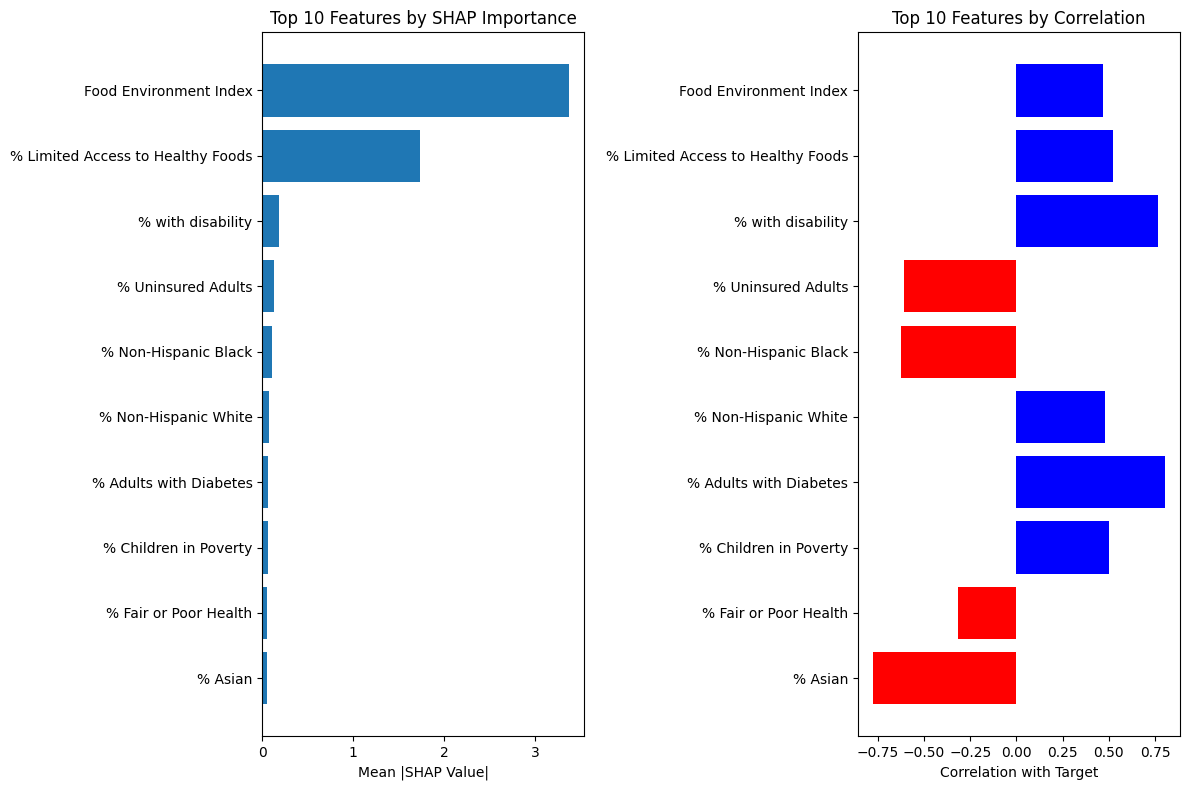

In [46]:
# Feature importance visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(10)

plt.subplot(1, 2, 1)
plt.barh(range(len(top_features)), top_features['Mean |SHAP|'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 10 Features by SHAP Importance')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
colors = ['red' if corr < 0 else 'blue' for corr in top_features['Correlation with Target']]
plt.barh(range(len(top_features)), top_features['Correlation with Target'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Correlation with Target')
plt.title('Top 10 Features by Correlation')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Prompt: Create comparison plot between MI Normalized and SHAP normalized bar plot

<Figure size 1000x600 with 0 Axes>

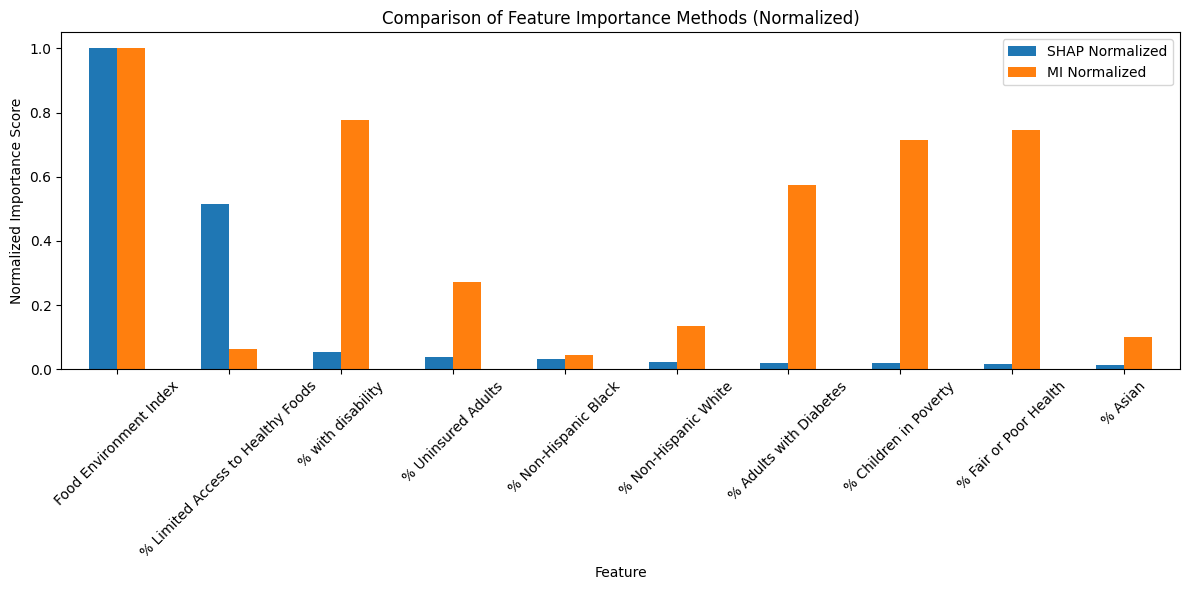

In [47]:
# Additional analysis: Compare feature importance methods
plt.figure(figsize=(10, 6))
methods_comparison = feature_importance_df.head(10)[['Feature', 'Mean |SHAP|', 'MI Score']]
methods_comparison = methods_comparison.set_index('Feature')

# Normalize for comparison
methods_comparison['SHAP Normalized'] = methods_comparison['Mean |SHAP|'] / methods_comparison['Mean |SHAP|'].max()
methods_comparison['MI Normalized'] = methods_comparison['MI Score'] / methods_comparison['MI Score'].max()

methods_comparison[['SHAP Normalized', 'MI Normalized']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Feature Importance Methods (Normalized)')
plt.ylabel('Normalized Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Prompt: Get the model performance R square, MSE, MAE, RMSE

In [48]:
# Model performance summary
print(f"\nModel Performance Summary:")
print(f"  R² Score: {r2:.4f}")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  Mean Absolute Error: {mae:.4f}")
print(f"  Root Mean Squared Error: {np.sqrt(mse):.4f}")


Model Performance Summary:
  R² Score: 0.9534
  Mean Squared Error: 0.5446
  Mean Absolute Error: 0.3792
  Root Mean Squared Error: 0.7380


Prompt: Get the key insight like top 3 most important feature by SHAP and the explain variance of the food insecurity

In [49]:
# Key insights
print(f"\nKey Insights:")
print(f"1. The model explains {r2*100:.1f}% of variance in food insecurity")
print(f"2. Top 3 most important features by SHAP:")
for i, row in feature_importance_df.head(3).iterrows():
    print(f"- {row['Feature']}: SHAP impact = {row['Mean |SHAP|']:.4f}")


Key Insights:
1. The model explains 95.3% of variance in food insecurity
2. Top 3 most important features by SHAP:
- Food Environment Index: SHAP impact = 3.3685
- % Limited Access to Healthy Foods: SHAP impact = 1.7320
- % with disability: SHAP impact = 0.1854


Prompt: Check the feature consistency

In [50]:
# Check for feature importance consistency
shap_top_3 = set(feature_importance_df.head(3)['Feature'])
mi_top_3 = set(feature_importance_df.nlargest(3, 'MI Score')['Feature'])
common_features = shap_top_3.intersection(mi_top_3)

print(f"3. Features consistently important across methods: {common_features}")


3. Features consistently important across methods: {'% with disability', 'Food Environment Index'}


Prompt: Save the resuts and print it

In [51]:
# Save final results
results_df = pd.DataFrame({
    'FIPS': X_test_orig.index[:50],
    'Actual_Food_Insecure': y_test_orig.iloc[:50].values,
    'Predicted_Food_Insecure': y_pred_test[:50],
    'Residual': y_test_orig.iloc[:50].values - y_pred_test[:50]
})
print(results_df)

    FIPS  Actual_Food_Insecure  Predicted_Food_Insecure   Residual
0    580                  14.5                12.717466   1.782534
1    107                  14.4                18.649012  -4.249012
2   1119                  14.4                16.163744  -1.763744
3     17                  17.6                11.285878   6.314122
4   1520                  21.0                12.361509   8.638491
5   1538                  15.6                14.620193   0.979807
6   1559                  12.9                 9.193949   3.706051
7   1715                  11.9                16.792458  -4.892458
8   2181                  12.3                11.126511   1.173489
9    853                  11.3                10.176935   1.123065
10   852                  12.1                18.861698  -6.761698
11   615                  13.3                11.363159   1.936841
12   335                  13.5                11.208786   2.291214
13  1425                  10.2                16.937666  -6.73

In [52]:

print(feature_importance_df)


                                    Feature  Mean |SHAP|  MI Score  \
9                    Food Environment Index     3.368458  0.701864   
11        % Limited Access to Healthy Foods     1.732038  0.045541   
6                         % with disability     0.185401  0.545276   
26                       % Uninsured Adults     0.131487  0.191602   
30                     % Non-Hispanic Black     0.111687  0.030454   
33                     % Non-Hispanic White     0.073994  0.093874   
29                   % Adults with Diabetes     0.063736  0.403486   
2                     % Children in Poverty     0.063143  0.501734   
21                    % Fair or Poor Health     0.055314  0.524369   
32                                  % Asian     0.048919  0.071693   
0                              % Unemployed     0.048664  0.136721   
25                    % Physically Inactive     0.041243  0.418985   
31                               % Hispanic     0.035128  0.091345   
27                  